## Import the packages needed

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn import feature_selection
from sklearn import model_selection

import nibabel as nib
from nilearn import image
from nilearn import input_data
from nilearn import plotting
from nilearn import decoding
from nilearn import datasets

import seaborn as sns; sns.set()

/home/juan/miniconda3/envs/fmri/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Description of the experimental design and data set

### Dataset
Yoshiharu Ikutani and Takatomi Kubo and Satoshi Nishida and Hideaki Hata and Kenichi Matsumoto and Kazushi Ikeda and Shinji Nishimoto (2020). fMRI dataset on program comprehension and expertise. OpenNeuro. [Dataset] doi: 10.18112/openneuro.ds002411.v1.1.0


#### Dataset description
Note that the original description is available at: [https://openneuro.org/datasets/ds002411/versions/1.0.0](https://openneuro.org/datasets/ds002411/versions/1.0.0)

This dataset contains fMRI data of code a snippet categorization task:
- The dataset contains experiment data for a total of 29 subjects.
- The code categories that the subjects could pick from were: `Math`, `String`, `Sort` and `Search`.
- The task is performed in 6 runs, each run has of 36 trials (36 different code categorization task), each run had the same number of instances for each code category (out of the 36 trials per run 8 were `Math`, `String`, `Sort` and `Search` code snippets).


#### fMRI images

Our data consists of the subjects' fMRI readings while performing a source code classification task. The data comes in a file that contains a 4 dimensional `numpy` array representing the brain's 3D volume over time (hence the four dimensions), each brain volume consists of a multitude of array elements, each containing the BOLD signal value of the voxel they represent.


### Experiment event labels and durations

Our second type of dataset is of a table-like structure telling us which event happens when, so we can then know which fMRI brain volumes correspond to which event.

In the table like structure each row corresponds to an experiment "event", during the experiment the subject is shown a stimulus (an event), then the subject is prompted with a questions about the stimulus (another event), then there is a period of rest (another event), and then the same succession of events is repeated a number of times. The duration of each event and the number of times each event happens is contained in this table like data.

The table like data will be used to extract the brain volumes that correspond to the stimulus events, so we can later use these brain volumes' data to train machine learning classifiers to perform the same code classification task as the subject, with the training data being the brain's BOLD signal.


### Experimental design

#### Step 1: Pre-process the fMRI images
In this step, we will use (outside of this notebook) use the `AFNI` (Analysis of Functional NeuroImages) preprocessing software to do things such a alignment, registration, concatenation and warping of our fMRI images.
In this notebook, we will then analyze how much the subjects moved between TRs, and we will discard the ones that moved too much (according to our arbitrary threshold). We will then pick a single subject to continue the analysis in this notebook for demonstration purposes.

#### Step 2: Stimulus-related data selection and extraction
In this step, using the data from *Step 1* we will extract only the data that corresponds to the event of the subjects actually seeing the code snippet in the screen, which we assume contains BOLD activation signals corresponding to the subjects trying to figure out which category corresponds to the stimulus.


#### Step 3: ROI exploration and selection
In this step, using the data from *Step 2* we will run tests to attempt to get an idea of areas of the brain (voxels) with BOLD activation levels that stand out from the rest. The tests we will on the functional brain image data are:
- **ANOVA**: we will analyze the variance of 
- **Searchlight**: Run a [searchlight analysis](https://www.pnas.org/content/103/10/3863) on the whole brain fMRI image. This will output values representing an estimate of the predictive power of groups of voxels. This is done by iteratively using groups of voxels' (one group at a time) signals to predict experiment's task labels. We are essentially trying to predict the label of the stimulus using small groups of voxels at a time, and we do this through the whole brain in attempt to find clusters of voxels that are likely to be predictive of the experiment's task labels.

Using the results of the above tests, select a brain ROI that will define the features that our ML classifiers will use for the code classification task.  


#### Step 4: Train ML classifiers and record their performance
Using the data from *Step 3* and cross-validation, train ML classifiers and record their performance


#### Step 5: Artificially lesion voxels and record resilience of classifiers
Artificially lesion voxels of sets of voxels using for testing the performance of the ML classifiers from *Step 4*, this can be dome by setting the signal value to 0

## Loading and preprocessing the data 

Below is code to calculate subject movement data during the experiment, in the future we will use this data to discard subjects that **moved too much** inside the MRI machine, since their data is likely to be unreliable 

In [2]:
def add_euclidian_distances(df):
    df['diff_last_dS'] = df['dS'] - df['dS'].shift(1)
    df['diff_last_dL'] = df['dL'] - df['dL'].shift(1)
    df['diff_last_dP'] = df['dP'] - df['dP'].shift(1)
    df.fillna(0)
    df['between_last_tr_movement_dS_dL_dP'] = np.sqrt(df['diff_last_dS']**2 + df['diff_last_dL']**2 + df['diff_last_dP']**2)
    df['tr_movement_from_origin_dS_dL_dP'] = np.sqrt(df['dS']**2 + df['dL']**2 + df['dP']**2)
    return df
    
def get_movement_summary(df, threshold=1.5):
    max_movements = (
        df[['between_last_tr_movement_dS_dL_dP','tr_movement_from_origin_dS_dL_dP']]
            .max(axis=0)
            .copy()
            .rename({
                "between_last_tr_movement_dS_dL_dP":"max_between_tr_movement_dS_dL_dP",
                "tr_movement_from_origin_dS_dL_dP":"max_tr_movement_from_origin_dS_dL_dP",
            })
    )
    above_thrs_move = (
        (df[['between_last_tr_movement_dS_dL_dP']]>threshold)
            .sum()
            .rename({
                "between_last_tr_movements_dS_dL_dP":"between_tr_movement_over_"+str(threshold)
            })
    )
            
    summary = pd.concat([max_movements,above_thrs_move])
    
    return summary

Load the subject movement data through the experiment 

In [3]:
subjs = ["sub-"+str(i) if i>9 else "sub-0"+str(i) for i in range(1,30)]

subj_dfs = {sub:pd.read_csv(
                        "./data/afni_head_motion/"+sub+"_results/dfile_rall.1D",
                        names=["roll","pitch","yaw", "dS","dL","dP"],
                        header=None,
                        sep="\s+")
            for sub in subjs}

subj_dfs["sub-08"]

,roll,pitch,yaw,dS,dL,dP
0,0.0111,0.0186,0.0211,0.0382,0.0164,-0.0270
1,-0.0078,-0.0224,-0.0005,-0.0023,-0.0087,-0.0332
2,0.0000,0.0000,-0.0000,-0.0000,0.0000,0.0000
3,-0.0003,-0.0080,-0.0055,0.0120,-0.0037,-0.0300
4,-0.0010,-0.0077,-0.0142,0.0165,-0.0115,-0.0199
...,...,...,...,...,...,...
1771,-0.5524,-0.6730,-0.3549,0.0801,-0.2601,0.1685
1772,-0.5518,-0.6597,-0.3533,0.0746,-0.2623,0.1629
1773,-0.5479,-0.6506,-0.3486,0.0610,-0.2586,0.2087
1774,-0.5440,-0.6596,-0.3533,0.0589,-0.2510,0.1722


Transform the a above data into a new dataframe with summary data of the subject's movement

In [4]:
subj_dfs = {k:add_euclidian_distances(v) for k,v in subj_dfs.items()}

threshold=2.01
subj_dfs = {k:get_movement_summary(v, threshold=threshold) for k,v in subj_dfs.items()}

subj_dfs = pd.DataFrame(subj_dfs)

subj_dfs = subj_dfs.T

subj_dfs

,max_between_tr_movement_dS_dL_dP,max_tr_movement_from_origin_dS_dL_dP,between_last_tr_movement_dS_dL_dP
sub-01,3.278866,5.494173,1.0
sub-02,0.364302,1.644770,0.0
sub-03,0.456543,1.159871,0.0
sub-04,0.244903,2.012193,0.0
sub-05,3.555287,4.073179,1.0
sub-06,1.257643,3.220474,0.0
sub-07,1.330638,1.702199,0.0
sub-08,2.002354,1.811183,0.0
sub-09,0.648505,5.408551,0.0
sub-10,3.136012,5.709135,3.0


Plot the movement summary statistics

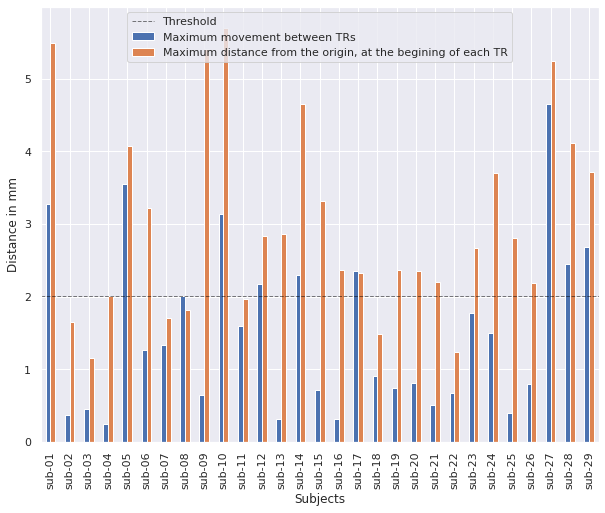

In [5]:
ax = subj_dfs[["max_between_tr_movement_dS_dL_dP", "max_tr_movement_from_origin_dS_dL_dP"]].plot(
    kind="bar",
    figsize=(10,8),
    ylabel="Distance in mm",
    xlabel="Subjects"
)

ax.axhline(
    y=threshold,
    color="black",
    alpha=0.5,
    linestyle="--",
    label="threshold",
    linewidth=1
)

plt.legend(["Threshold", "Maximum movement between TRs", "Maximum distance from the origin, at the begining of each TR"])

plt.savefig("./data/final/subjects_head_movement.pdf")

plt.show()

Let's discard all the subjects that had a between trial movement above `2.01 mm`

In [6]:
subj_dfs = subj_dfs[subj_dfs["between_last_tr_movement_dS_dL_dP"]==0]
subj_dfs

,max_between_tr_movement_dS_dL_dP,max_tr_movement_from_origin_dS_dL_dP,between_last_tr_movement_dS_dL_dP
sub-02,0.364302,1.644770,0.0
sub-03,0.456543,1.159871,0.0
sub-04,0.244903,2.012193,0.0
sub-06,1.257643,3.220474,0.0
sub-07,1.330638,1.702199,0.0
sub-08,2.002354,1.811183,0.0
sub-09,0.648505,5.408551,0.0
sub-11,1.599647,1.970085,0.0
sub-13,0.314771,2.857321,0.0
sub-15,0.707306,3.321673,0.0


Below is code to that will create a set of labels that we will later match with our actual brain fMRI data, these **labels will be used to know which fMRI readings are for the experiment event when the subjects are trying to categorize the code, and which code category the stimulus actually belongs to**

In [7]:
def trim_non_code(df):
    df = df.drop(df[~df["event_type"].isin(["source_code","response"])].index)
    df = df[["trial_no","event_type","stim_file","category","response","correctness"]]
    df = df.reset_index(drop=True)
    
    return df

def code_labels(df, nevents=36, vols_per_event=4):
    rows = []
    n = 0
    for i in range(0,len(df)-1,2):
        if df.loc[i]["trial_no"] != df.loc[i+1]["trial_no"]:
            raise NameError(f"expected {i} and {i+1} elemnts to have the same trial_no, got {labels_df.loc[i]['trial_no']} and {labels_df.loc[i+1]['trial_no']}")
        row = [
            df.loc[i]["trial_no"],
            df.loc[i]["stim_file"],
            df.loc[i]["category"],
            df.loc[i+1]["response"],
            True if df.loc[i+1]["correctness"] == "correct" else False,
        ]
        for _ in range(0,vols_per_event):
            rows.append(row)
        n+=1
        if n == nevents:
            break

    df = pd.DataFrame(rows, columns=["trial_no","stim_file","category","response","correct"])
    return df

def get_labels(df, column_name="category"):
    labels_list = []
    for i in range(0,len(df)-1,4):
        if df.loc[i]["trial_no"] != df.loc[i+1]["trial_no"]:
            raise NameError(f"expected {i} and {i+1} elemnts to have the same trial_no, got {df.loc[i]['trial_no']} and {df.loc[i+1]['trial_no']}")
        for _ in range(0,4):
            labels_list.append(df.loc[i][column_name])

    labels = np.array(labels_list)
    return labels

We will use subject **08** to demonstrate the rest of the study

Let's load the stimulus data for subject **08** that came in our dataset, note that the experiment had 6 runs, each with with 36 trials.
- Note: the stimulus event in each trial has a duration of 10 seconds, for our purposes, we will be using only the 8 seconds of data (which corresponds to 4 whole-brain fMRI volumnes)

In [8]:
sub = "08"

runs = [str(i) if i>9 else "0"+str(i) for i in range(1,7)]
print("runs: ", runs)
events = [pd.read_csv(
                        f"/home/juan/Documents/lenslab/ds002411-download/sub-{sub}/func/sub-{sub}_task-ProgramCategorization_run-{run}_events.tsv",
                        sep="\s+")
            for run in runs]
events = [ trim_non_code(ee) for ee in events]
events = [ code_labels(ee) for ee in events]
events[0]

runs:  ['01', '02', '03', '04', '05', '06']


,trial_no,stim_file,category,response,correct
0,1,0013_MATH_GCD.java,Math,Math,True
1,1,0013_MATH_GCD.java,Math,Math,True
2,1,0013_MATH_GCD.java,Math,Math,True
3,1,0013_MATH_GCD.java,Math,Math,True
4,2,0034_SEARCH_LSC.java,Search,Search,True
...,...,...,...,...,...
139,35,0045_SORT_IST.java,Sort,Sort,True
140,36,0025_SEARCH_LSC.java,Search,Search,True
141,36,0025_SEARCH_LSC.java,Search,Search,True
142,36,0025_SEARCH_LSC.java,Search,Search,True


In [9]:
labels = get_labels(events[0])
labels = [get_labels(ll) for ll in events]
labels = np.concatenate(labels)

print(labels.shape)
print("Distinct labels:", np.unique(labels, return_counts=True))

(864,)
Distinct labels: (array(['Math', 'Search', 'Sort', 'String'], dtype='<U6'), array([216, 216, 216, 216]))


Below we will create a boolean `numpy.ndarray` that we will use as a mask to **pick** the fMRI brain volumes that we want as specified:
- Remove the first 4 TRs (8 seconds) of each subject, these TRs correspond to a dummy trial
- Time shift of 3 TRs (6 seconds) to account for the hemodynamic lag
- Only keep the the first 4 TRs (8s/10s) our of the 5 TRs for when the subject is seeing the code snippet stimulus

In [10]:
# 1TR_baseline + CODE_4TR + code_1TR&response_2TR
condition_trial = np.concatenate(( np.zeros(1), np.ones(4), np.zeros(1+2)))
# 3TR_shift + 36*(1TR_baseline + CODE_4TR + code_1TR&response_2TR)
condition_trial = np.concatenate((np.zeros(3), np.tile(condition_trial, 36)))
# dummy trial: 4TRs
condition_trial = np.concatenate(( np.zeros(8), condition_trial ))
condition_trial = condition_trial[:296]
condition_trial = np.tile(condition_trial, 6)
condition_mask = condition_trial.astype(bool)
condition_mask

array([False, False, False, ...,  True,  True,  True])

Load the brain space template we will use to make sure all images are in the same **standard space**

In [11]:
mni = datasets.load_mni152_template();

<ipython-input-11-bf9a672b2947>:1: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  mni = datasets.load_mni152_template();


Actually load the fMRI data of the whole experiment for subject 08

In [12]:
allruns = image.load_img(f"/home/juan/Documents/lenslab/ds002411-download/afni_output_old/sub-{sub}_results/all_runs.{sub}.nii")
code_img = image.index_img(allruns, condition_mask)
code_img_mni = image.resample_to_img(code_img, mni)
code_img_mni.shape

(99, 117, 95, 864)

Load the brain mask image that our 3rd party preprocessing software created, this will be used as a guide of usable data of our fMRI images since there is a lot of data that falls our of the brain

In [13]:
brain_mask_img = image.load_img(f"/home/juan/Documents/lenslab/ds002411-download/afni_output_old/sub-{sub}_results/full_mask.08.nii")
brain_mask_img = image.resample_to_img(brain_mask_img, mni)

Save the movement summary dataframe in CSV format

In [14]:
subj_dfs.to_csv("data/final/movement_summaries.csv", header=True, index=True)

nib.save(code_img_mni, f"data/final/only_code_stimuli_sub-{sub}.nii.gz")

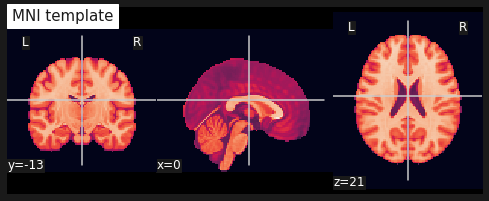

In [15]:
plotting.plot_img(mni, title="MNI template", black_bg=True);

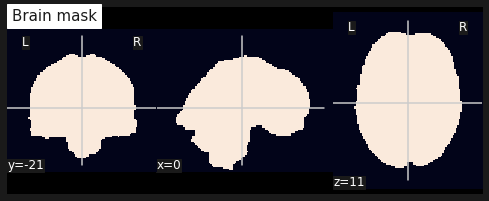

In [16]:
plotting.plot_img(brain_mask_img, title="Brain mask", black_bg=True);

In [18]:
code_img_mni.shape

(99, 117, 95, 864)

<OrthoSlicer3D: (99, 117, 95, 10)>

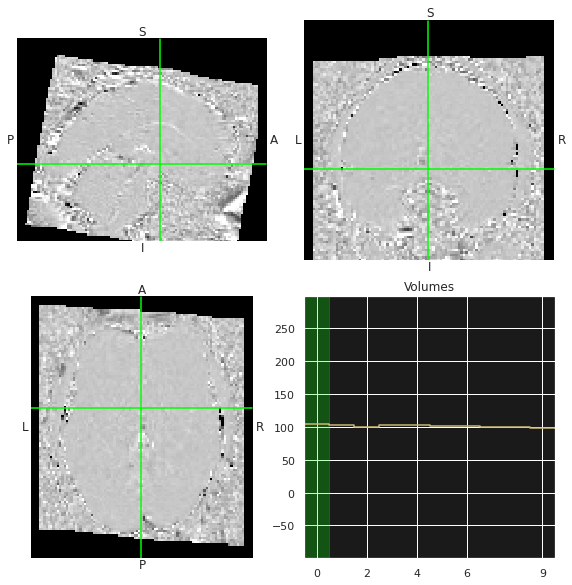

In [19]:
first_ten_images = image.index_img(code_img_mni, slice(0, 10))
first_ten_images.orthoview()

### ANOVA on functional image

Using our stimuli labels we can use ANOVA to get an idea of which voxels would make for better features for predicting the code category labels

In [20]:
nifti_masker = input_data.NiftiMasker(
    mask_img=brain_mask_img,
    standardize=True,
    memory='nilearn_cache',
    memory_level=1
)
code_img_mni_masked = nifti_masker.fit_transform(code_img_mni);

/home/juan/miniconda3/envs/fmri/lib/python3.9/site-packages/nilearn/input_data/nifti_masker.py:518: UserWarning: Persisting input arguments took 12.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(filter_and_mask,


In [21]:
f_values, p_values = feature_selection.f_classif(code_img_mni_masked, labels)
p_values = -np.log10(p_values)
# Don't allow p_values to be over 10
p_values[p_values > 10] = 10
# Transform the p_values data from (N-voxel rows) into brain space (3D array representing a volume)
p_unmasked = image.get_data(nifti_masker.inverse_transform(p_values))

A low p-value shows that at least 2 samples have different means which is a good indicator for a feature

In [38]:
f_values

array([4.8416376, 1.7706136, 1.3868313, ..., 1.3247914, 7.402476 ,
       3.6769176], dtype=float32)

In [39]:
p_values

array([2.6207333 , 0.82046366, 0.61008525, ..., 0.5767664 , 4.172699  ,
       1.9242407 ], dtype=float32)

Let's plot an arbitrary set of brain slice with the F-scores' p-values of each voxel, to get a visual idea of what ANOVA tells us about voxel BOLD signal variance in relation to the code category the subject was exposed to

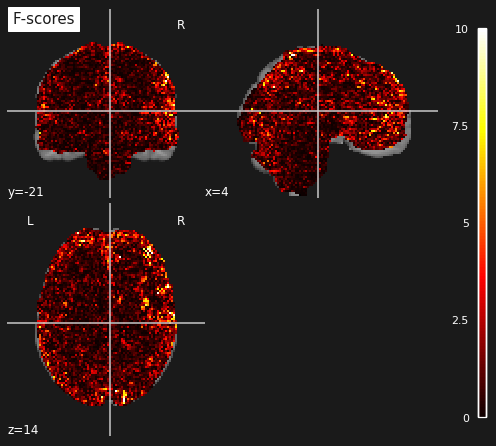

In [22]:
# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(brain_mask_img))
f_score_img = image.new_img_like(image.mean_img(code_img_mni), p_ma)

plotting.plot_stat_map(f_score_img,
    title="F-scores",
    display_mode="tiled", 
    black_bg=True, colorbar=True
)

### Searchlight

Below we will run a searchlight analysis to attempt to find clusters of voxels with predictive power in regards to our code category labels

In [23]:
cv = model_selection.KFold(n_splits=6)

searchlight = decoding.SearchLight(
    mask_img=brain_mask_img,
    radius=4,
    n_jobs=-1,
    verbose=1,
    cv=cv
)

The bellow code runs a searchlight analysis, it's commented because running it will take a very long time

In [24]:
# searchlight.fit(imgs=code_img_mni,y=labels)

# searchlight_img = image.new_img_like(image.mean_img(code_img_mni), searchlight.scores_)

# nib.save(searchlight_img, "data/searchlight_sliced-sub-08-allruns-scaled.nii.gz") 

Let's plot the searchlight scores we found for a set of brain slices sharing one voxel in common

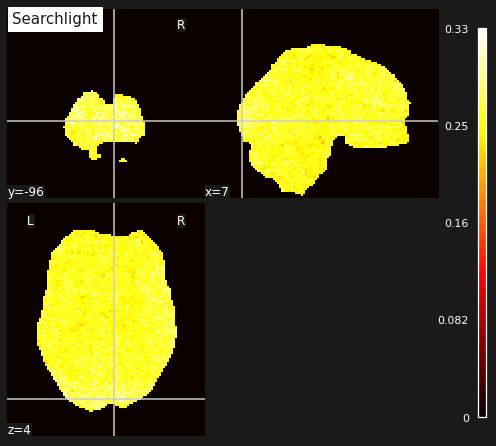

In [25]:
searchlight_img = image.load_img(f"data/searchlight_sliced-sub-{sub}-allruns-scaled.nii.gz")

plotting.plot_img(
    searchlight_img,
    bg_img=brain_mask_img,
    title="Searchlight",
    display_mode="tiled",
    cmap='hot', black_bg=True, colorbar=True
);

Let's plot the distribution of the searchlight scores skipping the non-brain data points. Remember that our categorization has 4 possibilities so a score of `0.25` would mean that the predictions have an accuracy close of chance (at random selection)

Totalusable searchlight voxels: 224285
Maximun searchlight value: 0.33796296296296297
Minimun searchlight value: 0.19444444444444442
Mean searchlight values: 0.25665733867045815
Standard deviation of searchlight values: 0.012932509803665419


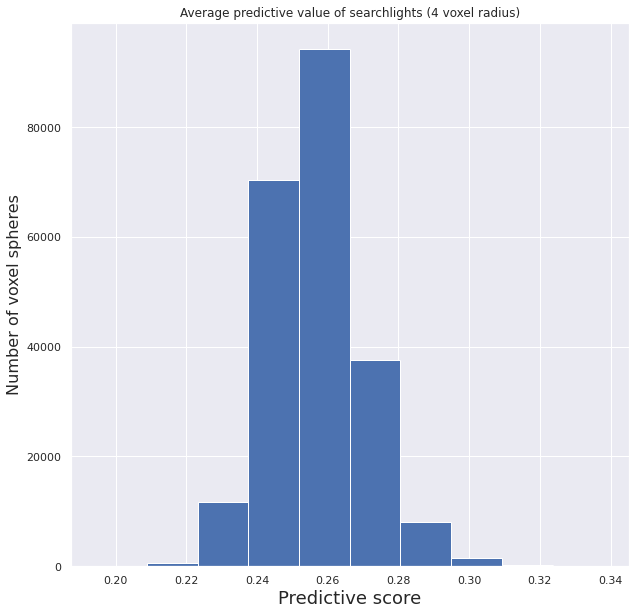

In [26]:
searchlight_data = searchlight_img.get_fdata()
searchlight_data = searchlight_data[searchlight_data>0]
print("Totalusable searchlight voxels:", len(searchlight_data))
max_sl = float(np.max(searchlight_data))
print("Maximun searchlight value:", max_sl)
min_sl = float(np.min(searchlight_data))
print("Minimun searchlight value:", min_sl)
print("Mean searchlight values:", np.mean(searchlight_data))
print("Standard deviation of searchlight values:", np.std(searchlight_data))

plt.figure(figsize=(10,10))
plt.title('Average predictive value of searchlights (4 voxel radius)')
plt.xlabel('Predictive score', fontsize=18)
plt.ylabel('Number of voxel spheres', fontsize=16)
plt.hist(searchlight_data)
plt.savefig('./data/final/searchlight_scores_distribution.png')
plt.show();

Let's try to plot our searchlights again, but this time let's use `0.25` as the minimum value that can be represented via colors

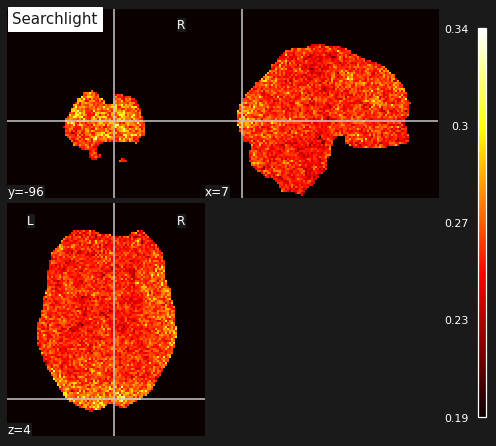

In [27]:
plotting.plot_img(
    searchlight_img,
    bg_img=mni,
    title="Searchlight",
    display_mode="tiled",
    vmin=min_sl,
    vmax=max_sl,
    cmap='hot',
    black_bg=True,
    colorbar=True
);

### ML classifiers

In this section we will pick (arbitraly) a brain ROI and train ML classifiers using the voxels within the ROI as features. The classification labels will be the actual category of the stimulus of the experiment. When training the classifiers we will use cross-validation to avoid overfitting, the folds of the cross validation will be the runs of the experiment.


Let's load our ROI mask and plot it


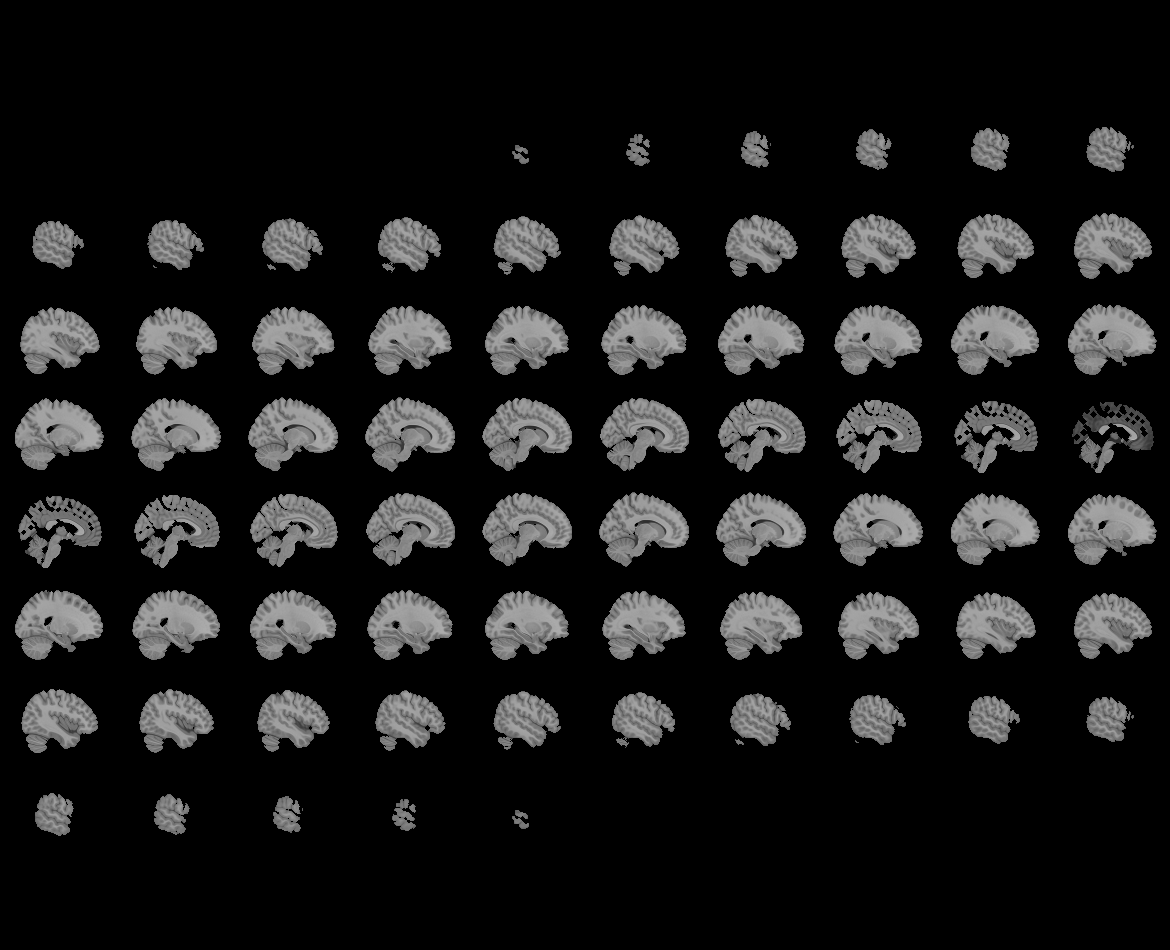
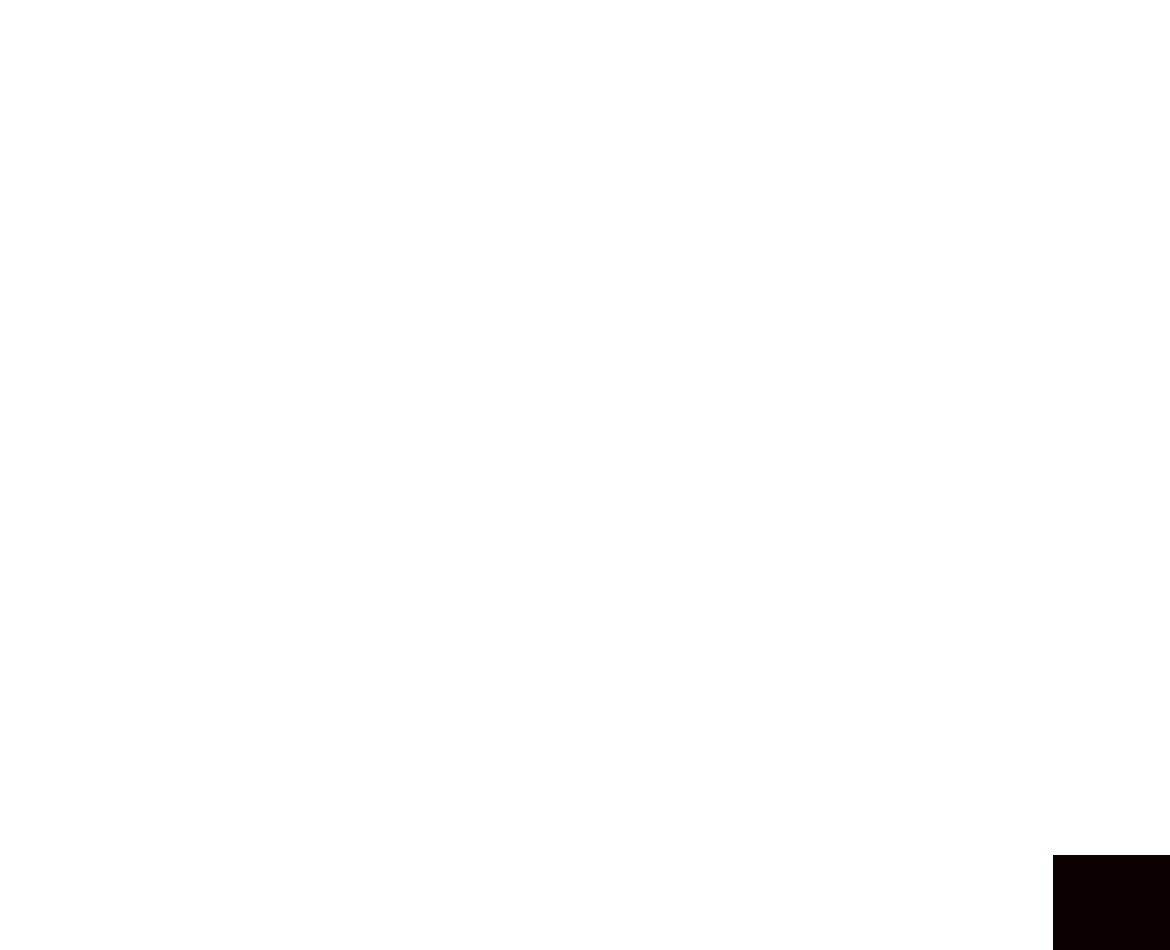

In [28]:
ifg_mask = image.load_img("./data/ifg_mask.nii.gz")
plotting.view_img(ifg_mask, title="IFG brain mask", colorbar=None)

Let's create our **runs labels** which we will use to know how to split our data to do cross-validation to test the performance of our classifiers.
Additionally, lets also print the information of the actual labels of each brain volume of our fMRI image.

In [29]:
n_volumes_per_run = code_img_mni.shape[3]//6
runs_labels = np.concatenate(
   (
       np.full(shape=n_volumes_per_run, fill_value=1, dtype=int),
       np.full(shape=n_volumes_per_run, fill_value=2, dtype=int),
       np.full(shape=n_volumes_per_run, fill_value=3, dtype=int),
       np.full(shape=n_volumes_per_run, fill_value=4, dtype=int),
       np.full(shape=n_volumes_per_run, fill_value=5, dtype=int),
       np.full(shape=n_volumes_per_run, fill_value=6, dtype=int),
   ), axis=None
)
print(f"Run labels shape: {runs_labels.shape}")
print(f"Run labels unique: {np.unique(runs_labels)}")

categories = np.unique(labels)
print(f"Stimulii labels shape: {labels.shape}")
print(f"Stimulii labels shape: {categories}")

Run labels shape: (864,)
Run labels unique: [1 2 3 4 5 6]
Stimulii labels shape: (864,)
Stimulii labels shape: ['Math' 'Search' 'Sort' 'String']


Below we will train 6 distinct types of classifiers using the voxels within the ROI as features, the training examples will be the corresponding voxels, and the labels will be the actual code snippet categories for the corresponding experiment trial 

In [30]:
# Classifiers to use
classifiers = ['dummy_classifier', 'svc_l2', 'svc_l1', 'logistic_l1',
               'logistic_l2', 'ridge_classifier']

import time
from nilearn.decoding import Decoder
from sklearn.model_selection import LeaveOneGroupOut

cv = LeaveOneGroupOut()
classifiers_data = {}

for classifier_name in sorted(classifiers):
    print(50 * '_')

    # The decoder has default score of "roc_auc"?
    decoder = Decoder(estimator=classifier_name, mask=ifg_mask,
                      standardize=True, cv=cv)
    t0 = time.time()
    decoder.fit(code_img_mni, labels, groups=runs_labels)

    classifiers_data[classifier_name] = {}
    classifiers_data[classifier_name]['score'] = decoder.cv_scores_

    print("%10s: %.2fs" % (classifier_name, time.time() - t0))
    for category in categories:
        print("    %14s vs all -- AUC: %1.2f +- %1.2f" % (
            category,
            np.mean(classifiers_data[classifier_name]['score'][category]),
            np.std(classifiers_data[classifier_name]['score'][category]))
        )

    # Adding the average performance per estimator
    scores = classifiers_data[classifier_name]['score']
    scores['AVERAGE'] = np.mean(list(scores.values()), axis=0)
    classifiers_data[classifier_name]['score'] = scores

__________________________________________________
dummy_classifier: 72.57s
              Math vs all -- AUC: 0.46 +- 0.04
            Search vs all -- AUC: 0.55 +- 0.05
              Sort vs all -- AUC: 0.50 +- 0.04
            String vs all -- AUC: 0.48 +- 0.04
__________________________________________________
logistic_l1: 88.66s
              Math vs all -- AUC: 0.61 +- 0.06
            Search vs all -- AUC: 0.56 +- 0.04
              Sort vs all -- AUC: 0.55 +- 0.03
            String vs all -- AUC: 0.65 +- 0.07
__________________________________________________
logistic_l2: 186.50s
              Math vs all -- AUC: 0.60 +- 0.09
            Search vs all -- AUC: 0.59 +- 0.09
              Sort vs all -- AUC: 0.53 +- 0.05
            String vs all -- AUC: 0.59 +- 0.05
__________________________________________________
ridge_classifier: 73.93s
              Math vs all -- AUC: 0.63 +- 0.05
            Search vs all -- AUC: 0.59 +- 0.04
              Sort vs all -- AUC: 0.57 +- 0.05


In [31]:
df_classifiers = pd.DataFrame(classifiers_data)

df_classifiers_pretty = pd.DataFrame.from_dict({(i,j): df_classifiers[i][j] 
                           for i in df_classifiers.keys() 
                           for j in df_classifiers[i].keys()},
                        orient='index')

df_classifiers_pretty["AVERAGE_AVG"] = np.mean(df_classifiers_pretty["AVERAGE"])

df_classifiers_pretty.to_csv("data/final/classifiers_performance_IFG.csv", header=True, index=True)

df_classifiers_pretty

,,Math,Search,Sort,String,AVERAGE,AVERAGE_AVG
dummy_classifier,score,"[0.4027777777777778, 0.4583333333333333, 0.532...","[0.5879629629629629, 0.5509259259259258, 0.476...","[0.5509259259259258, 0.513888888888889, 0.4398...","[0.4583333333333333, 0.47685185185185186, 0.55...","[0.49999999999999994, 0.49999999999999994, 0.5...",0.551397
logistic_l1,score,"[0.6622942386831275, 0.6121399176954733, 0.565...","[0.5051440329218106, 0.5347222222222222, 0.554...","[0.5223765432098766, 0.5635288065843621, 0.522...","[0.5524691358024691, 0.7592592592592593, 0.638...","[0.560570987654321, 0.6174125514403292, 0.5700...",0.602463
logistic_l2,score,"[0.6054526748971194, 0.6658950617283951, 0.595...","[0.4740226337448559, 0.5702160493827162, 0.542...","[0.5745884773662552, 0.5722736625514403, 0.496...","[0.5982510288065844, 0.6851851851851851, 0.567...","[0.5630787037037037, 0.6233924897119342, 0.550...",0.549361
ridge_classifier,score,"[0.676954732510288, 0.6412037037037036, 0.5735...","[0.5997942386831275, 0.5511831275720165, 0.555...","[0.51440329218107, 0.6466049382716049, 0.52083...","[0.5043724279835391, 0.7186213991769548, 0.572...","[0.5738811728395061, 0.63940329218107, 0.55574...",0.595207
svc_l1,score,"[0.6486625514403292, 0.6080246913580246, 0.572...","[0.51440329218107, 0.5411522633744857, 0.55864...","[0.5108024691358024, 0.5743312757201645, 0.528...","[0.5524691358024691, 0.7584876543209876, 0.648...","[0.5565843621399177, 0.6204989711934157, 0.576...",0.573302
svc_l2,score,"[0.5843621399176955, 0.6592078189300412, 0.588...","[0.4624485596707819, 0.5661008230452674, 0.537...","[0.5725308641975309, 0.565843621399177, 0.4884...","[0.5977366255144033, 0.6651234567901234, 0.558...","[0.5542695473251029, 0.6140689300411523, 0.543...",0.566722


In [32]:
print(list(df_classifiers_pretty.index.get_level_values(0)))
df_classifiers_pretty["AVERAGE_AVG"].to_list()

['dummy_classifier', 'logistic_l1', 'logistic_l2', 'ridge_classifier', 'svc_l1', 'svc_l2']


[0.5513974622770919,
 0.6024627057613169,
 0.5493612825788752,
 0.595207475994513,
 0.5733024691358025,
 0.5667223936899863]

Let's plot the classifiers' performance to get a visual comparison

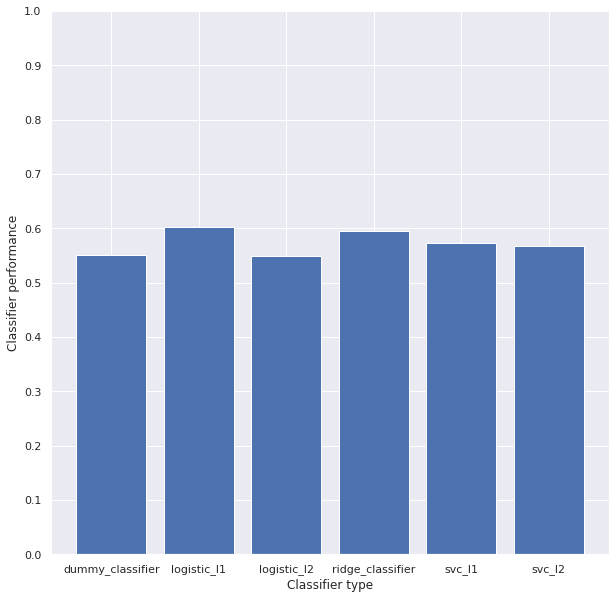

In [33]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
ax.set_xlabel("Classifier type")
ax.set_ylabel("Classifier performance")
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.1,0.1))

ax.bar(list(df_classifiers_pretty.index.get_level_values(0)), df_classifiers_pretty["AVERAGE_AVG"].to_list())

plt.savefig('./data/final/classifiers_performances.png');

## Publication-ready subpanel

Let's plot an interactive view of the ANOVA p-value of the F-scores in brain space


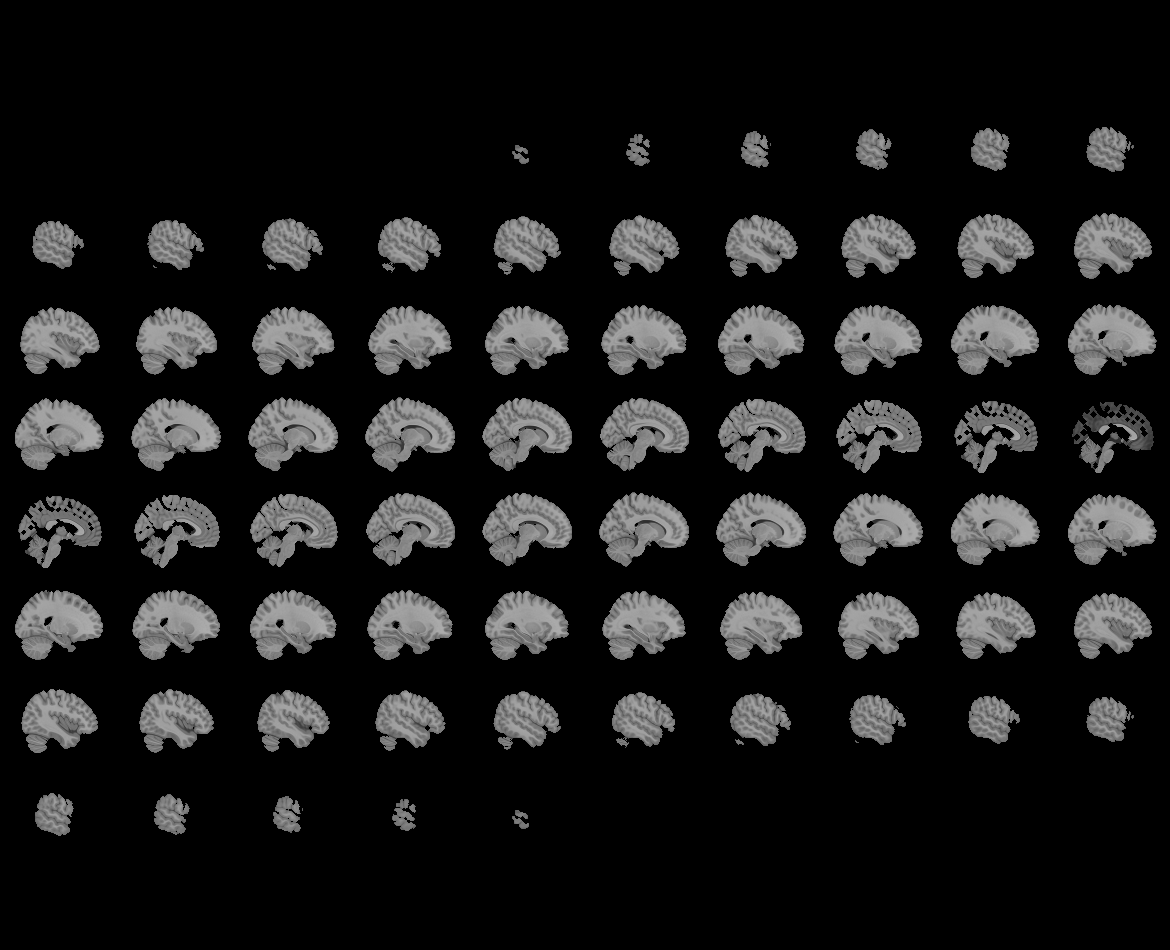
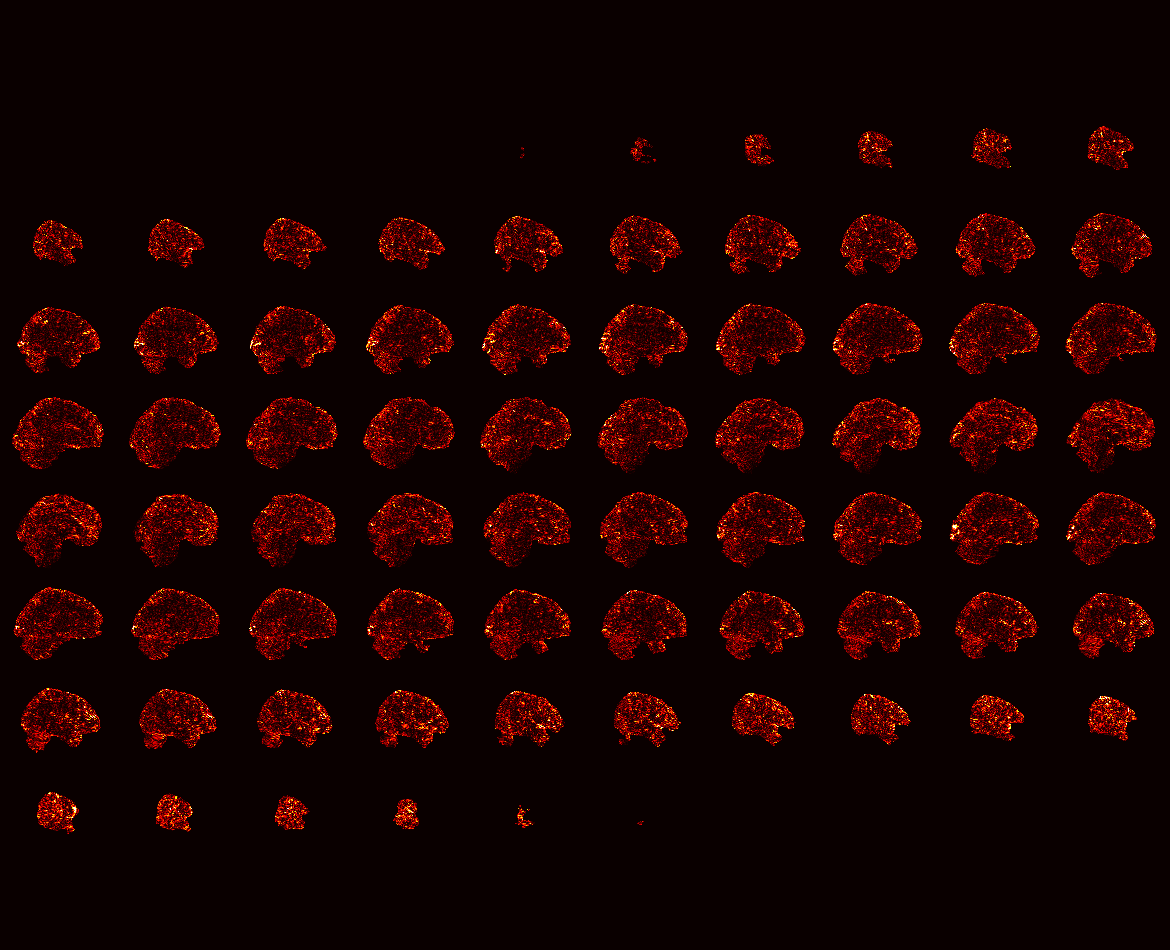

In [34]:
f_scores_view = plotting.view_img(f_score_img,
    title="ANOVA F-scores",
    threshold=None,
    vmin=np.min(p_values),
    vmax=np.max(p_values),
    cmap="hot",
    symmetric_cmap=False
)

f_scores_view.save_as_html("./data/final/f_scores_interactive.html")

f_scores_view

Let's plot an interactive view of the the searchlights accuracies in brain space


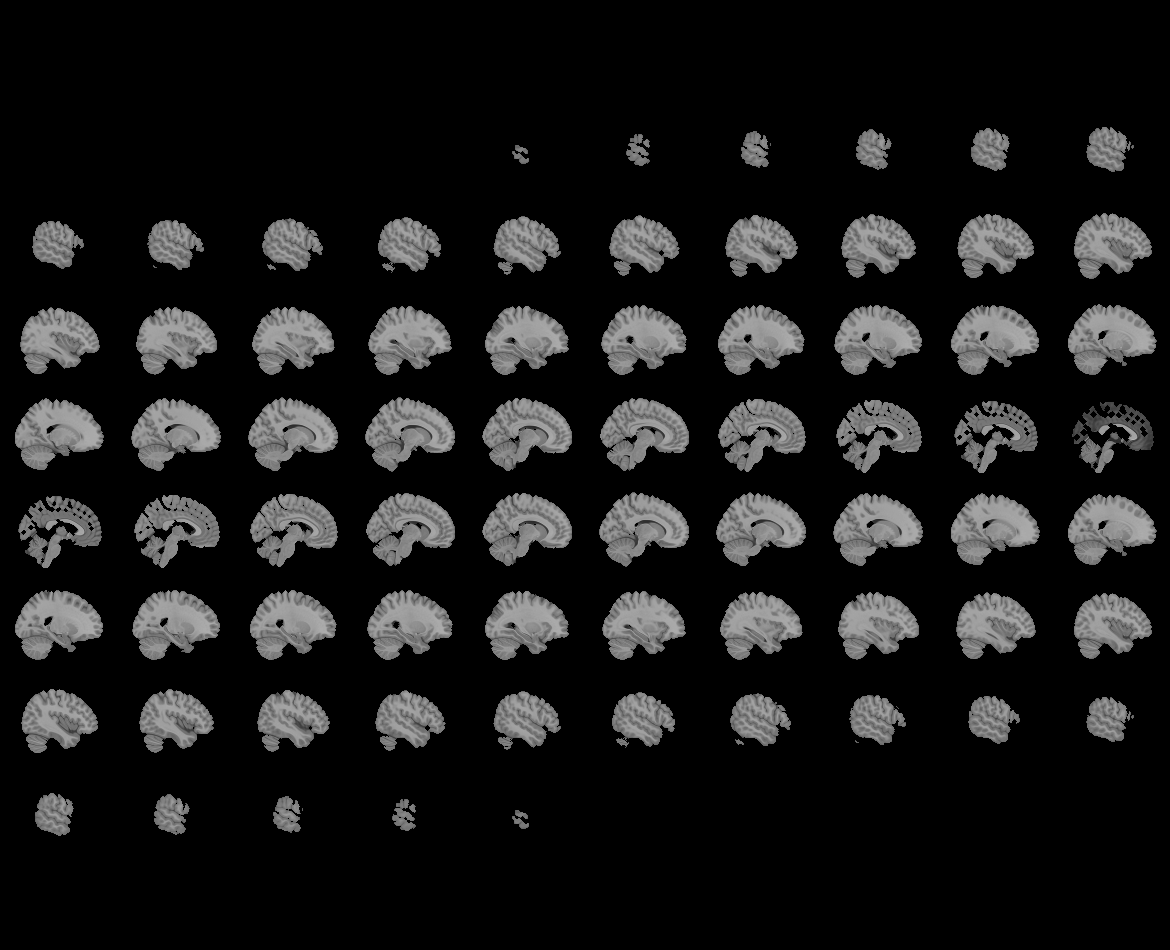
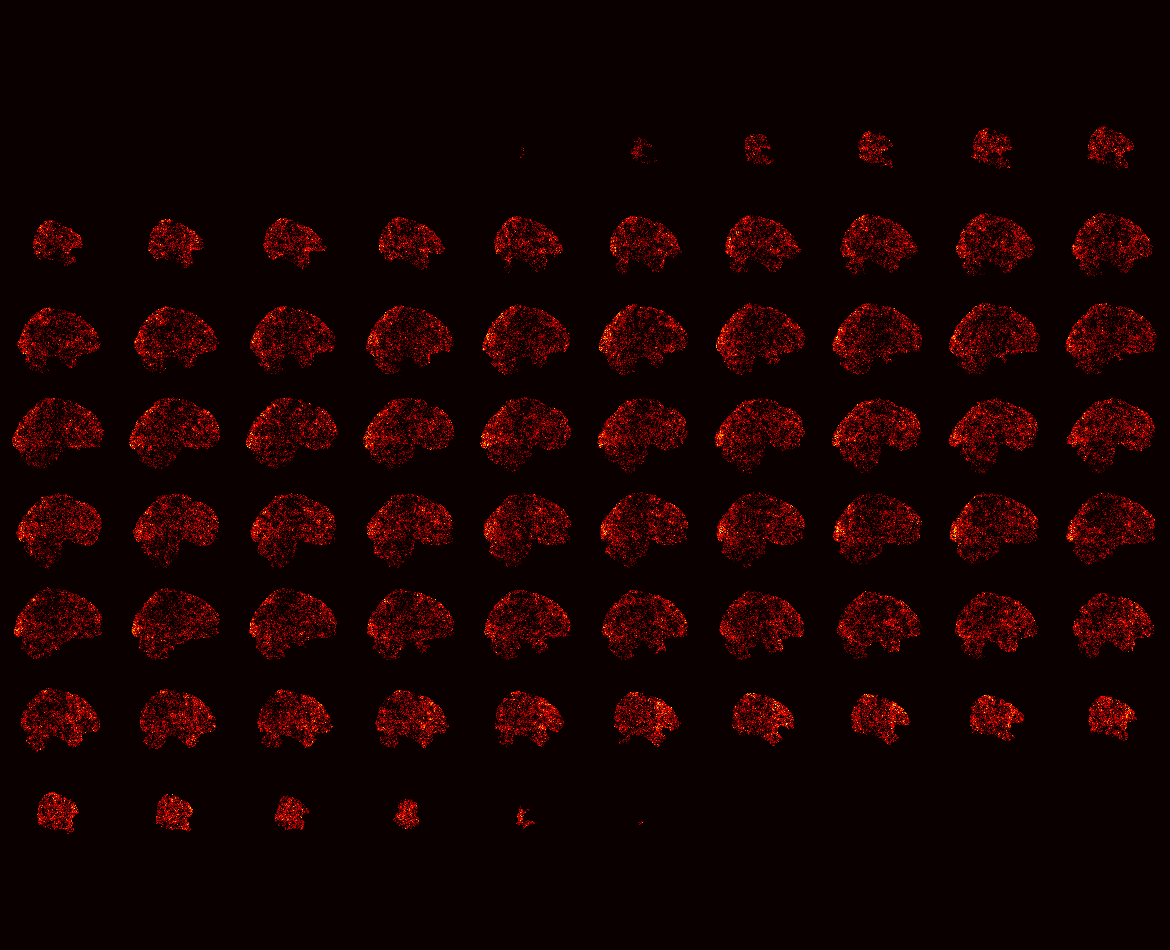

In [37]:
searchlight_view = plotting.view_img(searchlight_img,
    title="Searchlights' accuracy",
    threshold=None,
    vmin=.25,
    cmap="hot",
    symmetric_cmap=False
)

searchlight_view.save_as_html("./data/final/searchlight_view.html")

searchlight_view